### Developying machine learning model for time series forecast

In [92]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [93]:
features = pd.read_csv('../data/raw/features_data_set.csv')
sales = pd.read_csv('../data/raw/sales_data_set.csv')
stores = pd.read_csv('../data/raw/stores_data_set.csv')

In [94]:
sales['Date'] = pd.to_datetime(sales.Date, dayfirst=True)
sales = sales.sort_values(by=['Date'], ascending=True)

features['Date'] = pd.to_datetime(features.Date, dayfirst=True)
features = features.sort_values(by=['Date'], ascending=True)

sales['Date'] = pd.to_datetime(sales.Date, dayfirst=True)
sales = sales.sort_values(by=['Date'], ascending=True)

In [95]:
type_store = {row.Store:row.Type for _,row in stores.iterrows()}

In [96]:
sales_store_grouped = (sales[['Store','Weekly_Sales','Date']].groupby(['Store','Date']).agg({'Weekly_Sales':'sum'})
                       .reset_index())

In [97]:
new_dataset = pd.merge(sales_store_grouped, features, on=['Store','Date'], how='inner')

In [98]:
new_dataset = new_dataset.drop(columns=['MarkDown1','MarkDown2',
                                        'MarkDown3','MarkDown4','MarkDown5'])

new_dataset['IsHoliday'] = new_dataset['IsHoliday']*1

In [99]:
new_dataset['Type'] = new_dataset.Store.map(type_store)

new_dataset['Type'] = new_dataset.Type.map({'A':0,
                                            'B':1,
                                            'C':2})

In [100]:
new_dataset =  new_dataset.sort_values(by='Date',
                                       ascending=True)

In [101]:
from darts.timeseries import TimeSeries

Feature engineering

In [ ]:
new_dataset['month'] = new_dataset.Date.dt.month
new_dataset['day'] = new_dataset.Date.dt.day
new_dataset['year'] = new_dataset.Date.dt.year

In [150]:
from darts.dataprocessing.transformers.window_transformer import WindowTransformer

In [184]:
window_transformer = WindowTransformer([{'function':'mean',
                                         'mode':'rolling',
                                         'components':'Weekly_Sales',
                                         'window':2,
                                         'closed':'left'},
                        
                                         {'function':'mean',
                                         'mode':'rolling',
                                         'components':'Weekly_Sales',
                                         'window':5,
                                         'closed':'left'},
                                         
                                         {'function':'std',
                                         'mode':'rolling',
                                         'components':'Weekly_Sales',
                                         'window':2,
                                         'closed':'left'},
                                         
                                         {'function':'std',
                                         'mode':'rolling',
                                         'components':'Weekly_Sales',
                                         'window':5,
                                         'closed':'left'}],
                                         keep_non_transformed=True)

In [185]:
y_ts = TimeSeries.from_group_dataframe(new_dataset,
                                       time_col='Date',
                                       value_cols=['Weekly_Sales'],
                                       group_cols=['Store','Type'])

future_cov_ts = TimeSeries.from_group_dataframe(new_dataset,
                                                time_col='Date',
                                                value_cols=['month','day','year','IsHoliday'],
                                                group_cols=['Store','Type'])

past_cov_ts = TimeSeries.from_group_dataframe(new_dataset,
                                              time_col='Date',
                                              value_cols=['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales'],
                                              group_cols=['Store','Type']) 

In [186]:
past_cov_ts = window_transformer.transform(past_cov_ts)

In [187]:
past_cov_ts = [past_cov_ts[i].drop_columns('Weekly_Sales') for i in range(len(past_cov_ts))]

In [190]:
def train_test_timeseries(y:TimeSeries,
                          future_cov:TimeSeries=None,
                          past_cov:TimeSeries=None,
                          train_size:int=0.80)-> dict:
    
    train_y, test_y = [],[]
    train_future_cov, test_future_cov = [],[]
    train_past_cov, test_past_cov = [],[]
    
    for y_single in y:
        train_y_single, test_y_single = y_single.split_before(train_size)
        train_y.append(train_y_single)
        test_y.append(test_y_single)
    for future_cov_single in future_cov:
        train_future_cov_single, test_future_cov_single = future_cov_single.split_before(train_size)
        train_future_cov.append(train_future_cov_single)
        test_future_cov.append(test_future_cov_single)
    for past_cov_single in past_cov:
        train_past_cov_single, test_past_cov_single = past_cov_single.split_before(train_size)
        train_past_cov.append(train_past_cov_single)
        test_past_cov.append(test_past_cov_single)

    return {'y_timeseries':(train_y, test_y),
            'future_cov':(train_future_cov,test_future_cov),
            'past_cov':(train_past_cov, test_past_cov)}

In [191]:
dateset_for_fitting = train_test_timeseries(y_ts,future_cov=future_cov_ts,
                                            past_cov=past_cov_ts)

In [192]:
y_train, y_test = dateset_for_fitting['y_timeseries']
fut_cov_train, fut_cov_test = dateset_for_fitting['future_cov']
past_cov_train, past_cov_test = dateset_for_fitting['past_cov']

In [194]:
from darts.models.forecasting.xgboost import XGBModel
from darts.models.forecasting.lgbm import LightGBMModel
from darts.dataprocessing.transformers.scaler import Scaler

In [215]:
model = XGBModel(lags=[-1,-2,-5],
                 lags_future_covariates=[0],
                 lags_past_covariates=[-1,-2,-5])
model.fit(series=y_train,
          past_covariates=past_cov_train,
          future_covariates=fut_cov_train)

XGBModel(lags=[-1, -2, -5], lags_past_covariates=[-1, -2, -5], lags_future_covariates=[0], output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [216]:
model_lgbm = LightGBMModel(lags=[-2,-5],
                 lags_future_covariates=[0],
                 lags_past_covariates=[-1,-2,-5])
model_lgbm.fit(series=y_train,
          past_covariates=past_cov_train,
          future_covariates=fut_cov_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6683
[LightGBM] [Info] Number of data points in the train set: 4860, number of used features: 32
[LightGBM] [Info] Start training from score 1047808.513712


LightGBMModel(lags=[-2, -5], lags_past_covariates=[-1, -2, -5], lags_future_covariates=[0], output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [217]:
predictions = model.predict(series=y_train,
                            n=len(y_test[0]),
                            future_covariates=fut_cov_test,
                            past_covariates=past_cov_ts)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [218]:
predictions_lgbm = model_lgbm.predict(series=y_train,
                            n=len(y_test[0]),
                            future_covariates=fut_cov_test,
                            past_covariates=past_cov_ts)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<Axes: xlabel='Date'>

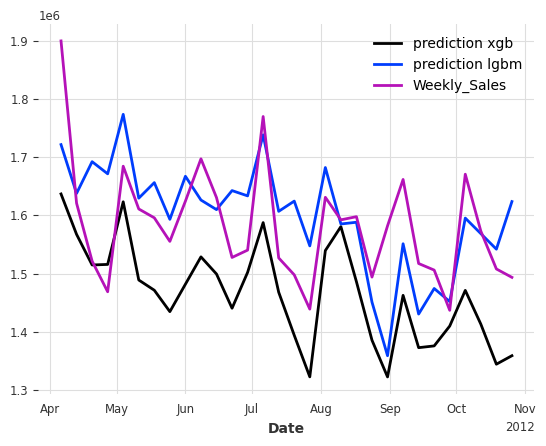

In [219]:
predictions[0].plot(label='prediction xgb')
predictions_lgbm[0].plot(label='prediction lgbm')
y_test[0].plot()

<Axes: xlabel='Date'>

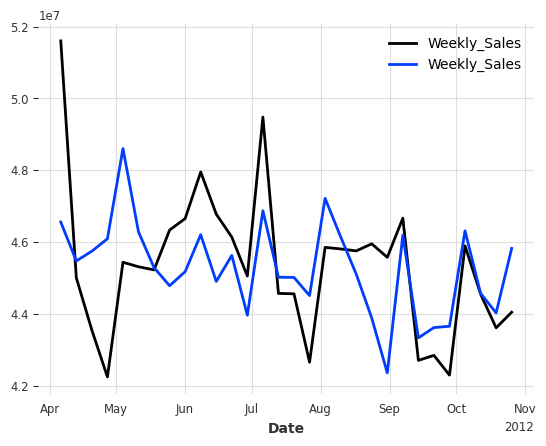

In [220]:
sum(y_test[1:]).plot('Real Value')
#sum(predictions_lgbm[1:]).plot()
sum(predictions[1:]).plot()


<Axes: xlabel='Date'>

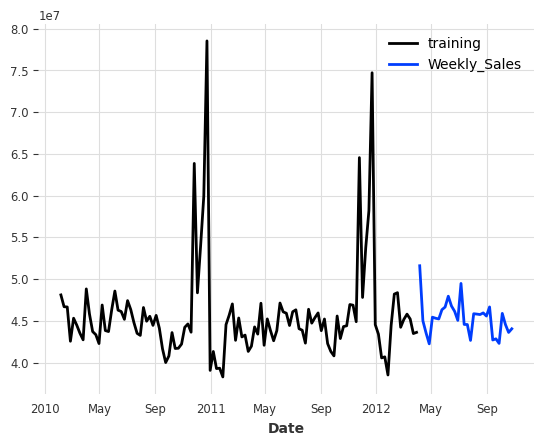

In [221]:
sum(y_train[1:]).plot(label='training')
sum(y_test[1:]).plot()

<Axes: xlabel='Date'>

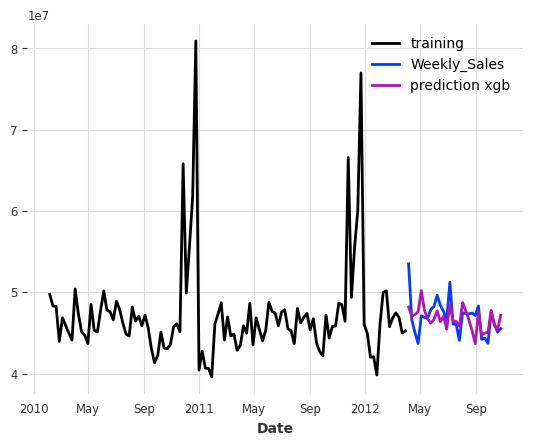

In [223]:
sum(y_train).plot(label='training')
sum(y_test).plot()
#sum(predictions_lgbm).plot(label='prediction lgbm')
sum(predictions).plot(label='prediction xgb')

In [224]:
from darts.metrics.metrics import mape

In [225]:
lgbm_historical_forecast = model_lgbm.historical_forecasts(series=y_ts,
                                                        future_covariates=future_cov_ts,
                                                        past_covariates=past_cov_ts,
                                                        start=0.5,
                                                        forecast_horizon=10, 
                                                        retrain=False,
                                                        last_points_only=False)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<Axes: xlabel='Date'>

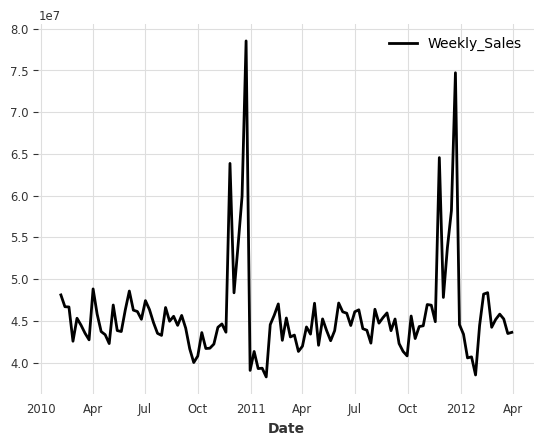

In [226]:
sum(y_train[1:]).plot()

In [227]:
xgb_historical_forecast = model.historical_forecasts(series=y_ts,
                                                        future_covariates=future_cov_ts,
                                                        past_covariates=past_cov_ts,
                                                        start=0.5,
                                                        forecast_horizon=10, 
                                                        retrain=False,
                                                        last_points_only=False)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [228]:
len(xgb_historical_forecast[0])

63

In [229]:
forecaste_plots = []

for j in range(len(xgb_historical_forecast[0])):
    for i in range(len(xgb_historical_forecast)):
        if i == 0:
            plot = xgb_historical_forecast[i][j]
        else:
            plot += xgb_historical_forecast[i][j]

    forecaste_plots.append(plot)
    

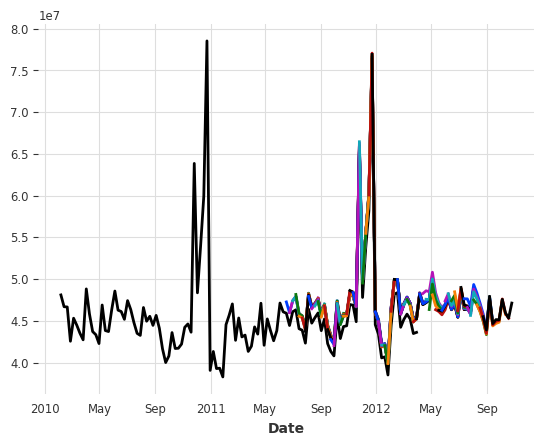

In [230]:
sum(y_train[1:]).plot()
for p in forecaste_plots:
    p.plot(default_formatting=False)
    legend = plt.legend()  # Crea la leyenda
    legend.set_visible(False)

In [69]:
backtest_xgb = model.backtest(series=y_ts,
                                   historical_forecasts=xgb_historical_forecast,
                                   metric=mape,
                                   last_points_only=False,
                                   reduction=None)
backtest_lgbm = model_lgbm.backtest(series=y_ts,
                                   historical_forecasts=lgbm_historical_forecast,
                                   metric=mape,
                                   last_points_only=False,
                                   reduction=None)

In [70]:
means_of_metrics_xgb = [np.mean(metric) for metric in backtest_xgb]
means_of_metrics_lgbm = [np.mean(metric) for metric in backtest_lgbm]

(array([4., 7., 8., 9., 8., 3., 3., 2., 0., 1.]),
 array([1.89867768, 2.58803963, 3.27740158, 3.96676353, 4.65612548,
        5.34548743, 6.03484938, 6.72421133, 7.41357328, 8.10293523,
        8.79229718]),
 <BarContainer object of 10 artists>)

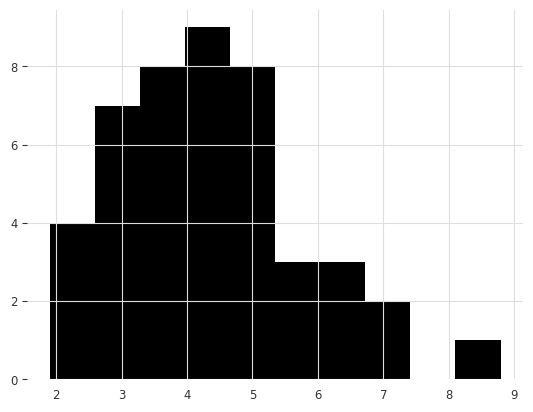

In [71]:
plt.hist(means_of_metrics_xgb)

(array([ 5.,  7., 14.,  8.,  5.,  5.,  0.,  0.,  0.,  1.]),
 array([ 2.40675213,  3.41894055,  4.43112898,  5.4433174 ,  6.45550583,
         7.46769425,  8.47988268,  9.4920711 , 10.50425953, 11.51644795,
        12.52863638]),
 <BarContainer object of 10 artists>)

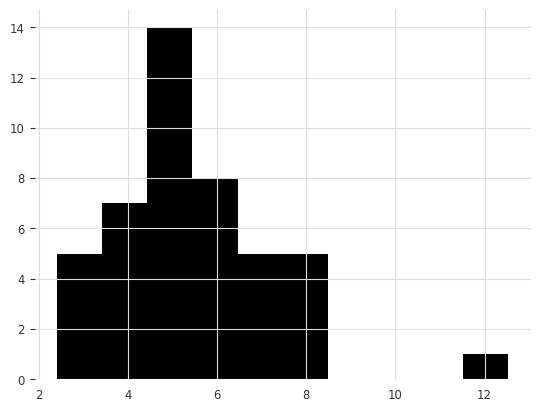

In [72]:
plt.hist(means_of_metrics_lgbm)

In [73]:
np.mean([np.mean(metric) for metric in backtest_xgb])

4.333083329384677

In [74]:
np.mean([np.mean(metric) for metric in backtest_lgbm])

5.398686043450345

Total model predictions performance

In [75]:
total_sales_predictions_xgb = sum(predictions[1:])
total_sales_predictions_lgbm = sum(predictions_lgbm[1:])

In [76]:
mape_xgb = mape(actual_series=sum(y_test[1:]),
                pred_series=total_sales_predictions_xgb)
mape_lgbm = mape(actual_series=sum(y_test[1:]),
                pred_series=total_sales_predictions_lgbm)

In [77]:
print('XGB MAPE%')
print(mape_xgb)
print('=============================')
print('LGBM MAPE%')
print(mape_lgbm)

XGB MAPE%
2.7607280613889715
LGBM MAPE%
3.054943688141347
